# Intra - Inter connectivity : comparing quocients to EDSS/SDMT

Create the first figure, that tries to replicate the correlation between intra and inter connectivity
described in existing papers

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statannotations.Annotator import Annotator
import itertools 

# ignore warnings for easier plotting
import warnings
warnings.filterwarnings("ignore")

from load_data import load_data

In [56]:
sns.set(style='darkgrid', context='paper', palette='Set1', font="serif")

In [57]:
# Hue colors order and names
# auxiliar dict to put correct order in the figure
map_hue_color = {
    "EDSS_group": ["EDSS<3", "EDSS>=3"],
    "SDMT_group": ["SDMT>=40", "SDMT<40"],
    "G_norm": ['G_z<=0', 'G_z>0'], 
    "Corr_norm": ['C_z<=0', 'C_z>0'],
    "disease": ["HC", "MS"],
    "GROUP": ["HC", "CIS", "RRMS", "SPMS", "PPMS"],
    "CENTER": ["CLINIC", "MAINZ", "MILAN", "NAPLES", "OSLO", "LONDON", "AMSTERDAM"],
    "groups" : ["HC", "EDSS<3", "EDSS>=3", "SDMT>=40", "SDMT<40"]
    # "GROUP": ["HC", "RRMS", "SPMS", "PPMS"]
}

# get the progressives together.
mapping_prog = {
    "HC": "HC",
    "CIS": "CIS", 
    "RRMS": "RRMS", 
    "SPMS": "PMS", 
    "PPMS": "PMS"
}

df_merged = load_data()
print(df_merged.columns.values)

['SubjID' 'DOB' 'SEX' 'GROUP' 'ONSET_DATE' 'MR_DATE' 'TREATMENT_AT_MRI'
 'TREATMENT' 'EDSS' 'YED' 'SDMT' 'RAO_SRTS' 'RAO_SRTR' 'RAO_SRTD'
 'RAO_10_36_SRTR' 'RAO_10_36_SRTD' 'RAO_WLG' 'RAO_PASAT' 'CENTER'
 'FMRI_TR' 'FMRI_NSCANS' 'FMRI_SCANTIME' 'AGE' 'DD' 'BICAMS_CVLT2'
 'BICAMS_BVMTR' 'NPS_x' '9HPT_dH' '9HPT_ndH' 'T25FW' 'motor_x'
 'Datecognitiveevaluation' 'TypeRAO' 'RAO_PASAT2sec'
 'RAO_WLGperseveration' 'RAO_WLGintrusion' 'Right9HPT' 'Left9HPT'
 'MFIS_TOTAL' 'MFIS_PHYS_FUNCT' 'MFIS_COGN_FUNCT' 'MFIS_SOCIAL_FUNCT'
 'BDI_II' '9HPT_average' 'notes_NPS' '9HPT_dH_' 'DWI_PROT' 'SCANNER'
 'SRTL_sum' 'PASAT2' 'WRDLG' 'QC' 'CENTER2' 'GM' 'GMF' 'WM' 'WMF' 'CSF'
 'CSFF' 'LV' 'LVF' 'BPF' 'RDwm_mean' 'RDwm_std' 'RDlwm_mean' 'RDlwm_std'
 'RDl_mean' 'RDl_std' 'RD_gm' 'RD_gmwm' 'Meta_x' 'Meta_noreg'
 'Unnamed: 21' 'Unnamed: 22' 'Unnamed: 23' 'FAwm_mean' 'FAwm_std'
 'FAlwm_mean' 'FAlwm_std' 'FAl_mean' 'FAl_std' 'FA_gm' 'FA_gmwm'
 'CC_Sag_area' 'CC_Posterior' 'CC_Mid_Posterior' 'CC_Central'
 'CC_Mid

In [58]:
## Compute all quocients

# maybe we need to normalize it beforehand 

df_merged["q_Comm_spl"] = df_merged["Comm_ratio"] / df_merged["SC_spl_full"]
df_merged["q_Comm_eff"] = df_merged["Comm_ratio"] / df_merged["SC_eff_full"]
df_merged["q_CC_spl"] = df_merged["CC_ratio_area"] / df_merged["SC_spl_full"]
df_merged["q_CC_eff"] = df_merged["CC_ratio_area"] / df_merged["SC_eff_full"]

In [59]:
print(len(df_merged))
x1 = "q_Comm_spl"
x2 = "q_Comm_eff"
x3 = "q_CC_spl"
x4 = "q_CC_eff"

# Select only MS
df_merged_nona = df_merged[df_merged["disease"] == "MS"]
print(len(df_merged_nona))
df_merged_nona = df_merged_nona.dropna(subset=[x1, x2, x3, x4, "EDSS", "SDMT"])
print(len(df_merged_nona))

697
489
478


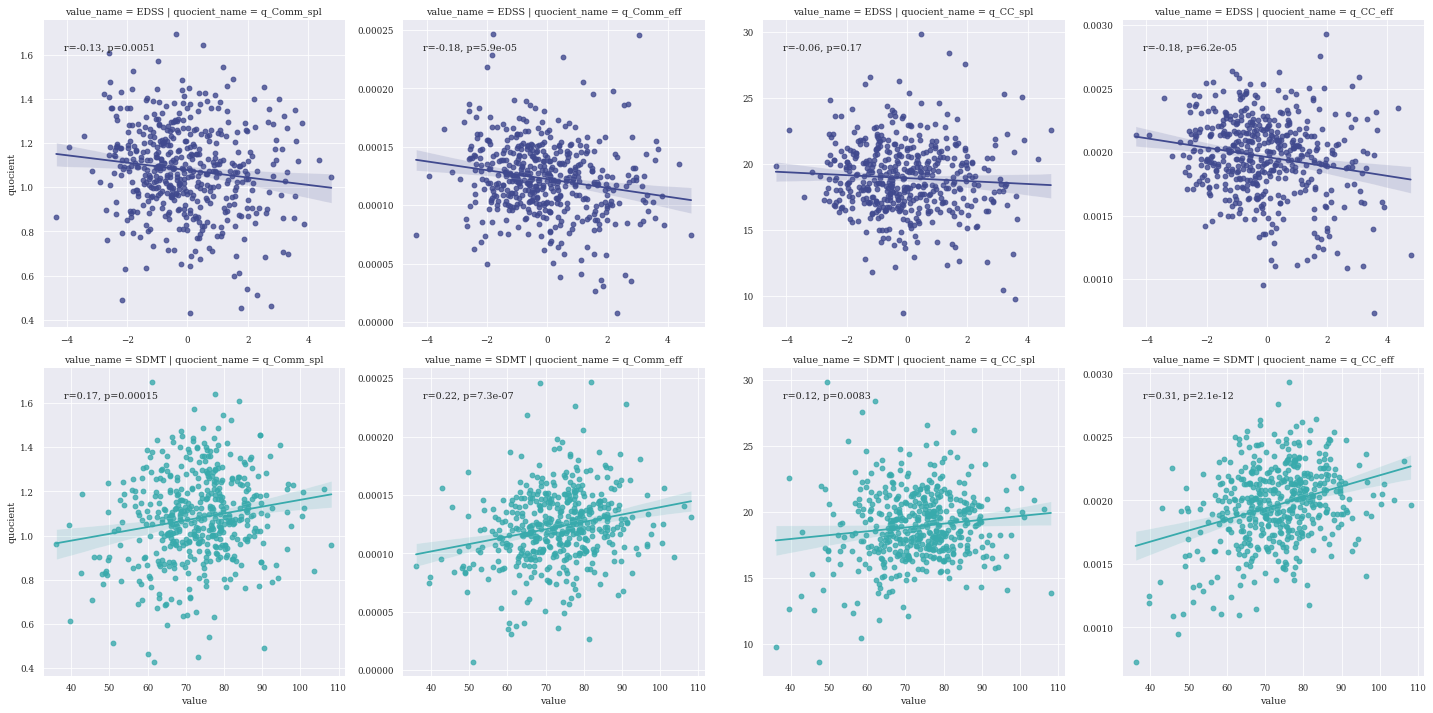

In [70]:
def annotate(col1, col2, data, multihue=False, **kwargs):
    if len(data[col1]) >= 2 or len(data[col2]) >= 2:
        r, p = stats.pearsonr(data[col1], data[col2])
        ax = plt.gca()

        # hardcoded, udpate if working with other labels
        x_pos = 0.05
        if multihue:
            label = kwargs["label"]
            dict_of_labels = {"CIS": 0, "RRMS": 1, "PMS": 2, 'MS':0, 'HC':1}
            y_pos = 0.9 - dict_of_labels[kwargs["label"]]*0.05
        else:
            label =  " "
            y_pos = 0.9
        
        ax.text(x_pos, y_pos, f'{label} ' + 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)

to_correct_for = 'AGE + C(CENTER) + C(SEX)'

results = smf.ols(f'{x1} ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"{x1}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x2} ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"{x2}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x3} ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"{x3}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x4} ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"{x4}"] = results.resid + results.params.Intercept

results = smf.ols(f'EDSS ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"EDSS"] = results.resid + results.params.Intercept

results = smf.ols(f'SDMT ~ {to_correct_for}', data=df_merged_nona).fit()
df_merged_nona[f"SDMT"] = results.resid + results.params.Intercept


# First quocient
df_x1_y1 = pd.DataFrame({"quocient": df_merged_nona[x1].values, "value": df_merged_nona["EDSS"].values})
df_x1_y1["quocient_name"] = x1
df_x1_y1["value_name"] = "EDSS"

df_x1_y2 = pd.DataFrame({"quocient": df_merged_nona[x1].values, "value": df_merged_nona["SDMT"].values})
df_x1_y2["quocient_name"] = x1
df_x1_y2["value_name"] = "SDMT"

# Second quocient
df_x2_y1 = pd.DataFrame({"quocient": df_merged_nona[x2].values, "value": df_merged_nona["EDSS"].values})
df_x2_y1["quocient_name"] = x2
df_x2_y1["value_name"] = "EDSS"

df_x2_y2 = pd.DataFrame({"quocient": df_merged_nona[x2].values, "value": df_merged_nona["SDMT"].values})
df_x2_y2["quocient_name"] = x2
df_x2_y2["value_name"] = "SDMT"

# Third quocient
df_x3_y1 = pd.DataFrame({"quocient": df_merged_nona[x3].values, "value": df_merged_nona["EDSS"].values})
df_x3_y1["quocient_name"] = x3
df_x3_y1["value_name"] = "EDSS"

df_x3_y2 = pd.DataFrame({"quocient": df_merged_nona[x3].values, "value": df_merged_nona["SDMT"].values})
df_x3_y2["quocient_name"] = x3
df_x3_y2["value_name"] = "SDMT"

# Fourth quocient
df_x4_y1 = pd.DataFrame({"quocient": df_merged_nona[x4].values, "value": df_merged_nona["EDSS"].values})
df_x4_y1["quocient_name"] = x4
df_x4_y1["value_name"] = "EDSS"

df_x4_y2 = pd.DataFrame({"quocient": df_merged_nona[x4].values, "value": df_merged_nona["SDMT"].values})
df_x4_y2["quocient_name"] = x4
df_x4_y2["value_name"] = "SDMT"

# concatenate the four dataframes
df_intra_inter = pd.concat([df_x1_y1, df_x1_y2, df_x2_y1, df_x2_y2, df_x3_y1, df_x3_y2, df_x4_y1, df_x4_y2])

g = sns.lmplot(data=df_intra_inter, x="value", hue="value_name", y="quocient", row="value_name", col="quocient_name", facet_kws={"sharex":False, "sharey":False}, 
               legend=False, legend_out=False, scatter_kws={"alpha":0.8}, palette="mako")
g.map_dataframe(annotate, "value", "quocient", multihue=False)

## Create the correct titles
"""
fig = g.fig
fig.suptitle("Intra - Inter hemispheric connectivity")
a1 = fig.axes[0]
a1.set_title("Comm. ratio - SPL")
a1.set_xlabel("Commissural ratio")
a1.set_ylabel("Average SPL")

a2 = fig.axes[1]
a2.set_title("Comm. ratio - Efficiency")
a2.set_xlabel("Commissural ratio")
a2.set_ylabel("Efficiency")

a3 = fig.axes[2]
a3.set_title("CC Area ratio - SPL")
a3.set_xlabel("CC Area ratio")
a3.set_ylabel("Average SPL")

a4 = fig.axes[3]
a4.set_title("CC Area# build 4 dataframes manually, with columns intra/inter which means the variable intra/inter for that 
 ratio - Efficiency")
a4.set_xlabel("CC Area ratio")
a4.set_ylabel("Efficiency")
"""
# plt.legend(bbox_to_anchor=(1.05, 1.1), loc='upper left', borderaxespad=0)
plt.tight_layout()

plt.savefig("/home/extop/GERARD/PAPERS/PAPER_COBRA/FIGURES/Quocient_vs_EDSSSDMT.pdf", dpi=300)

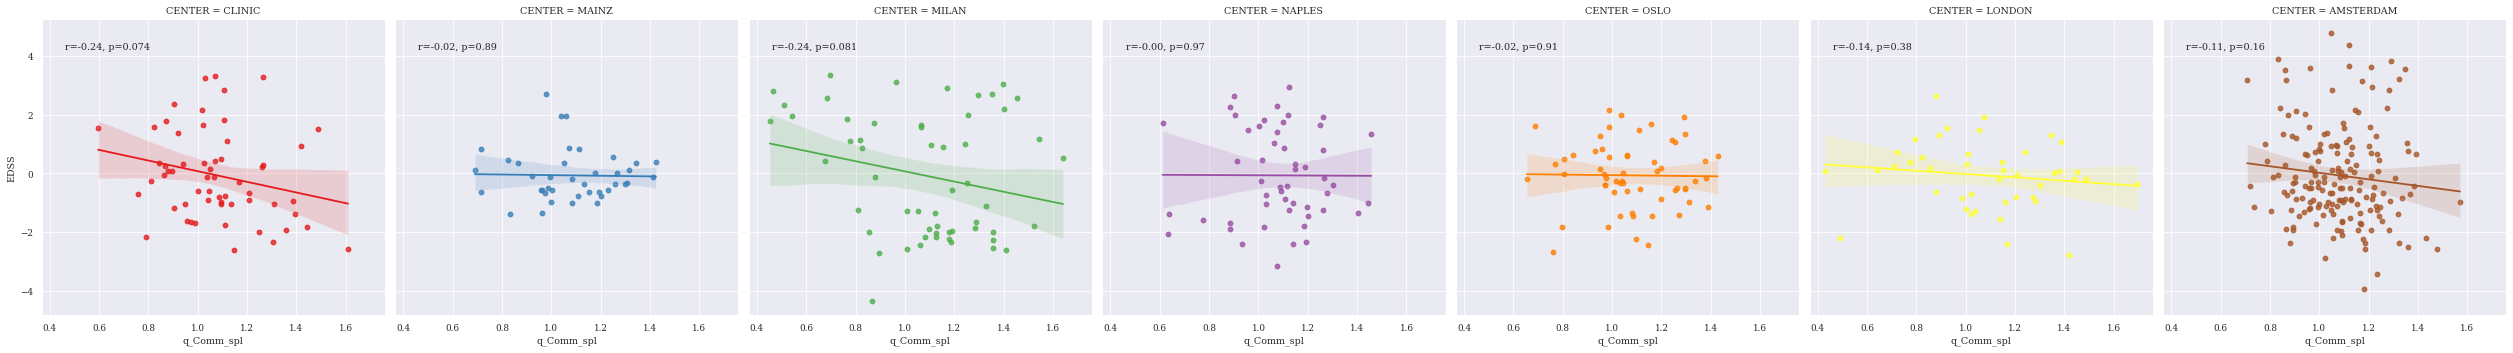

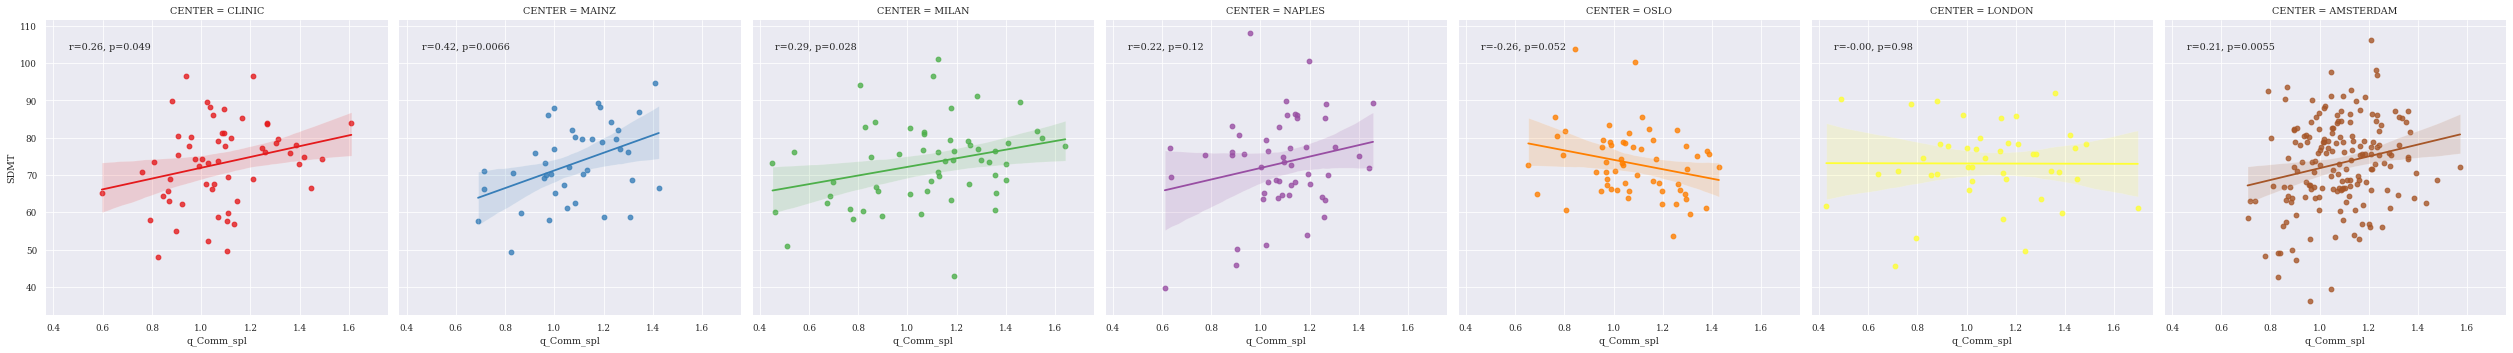

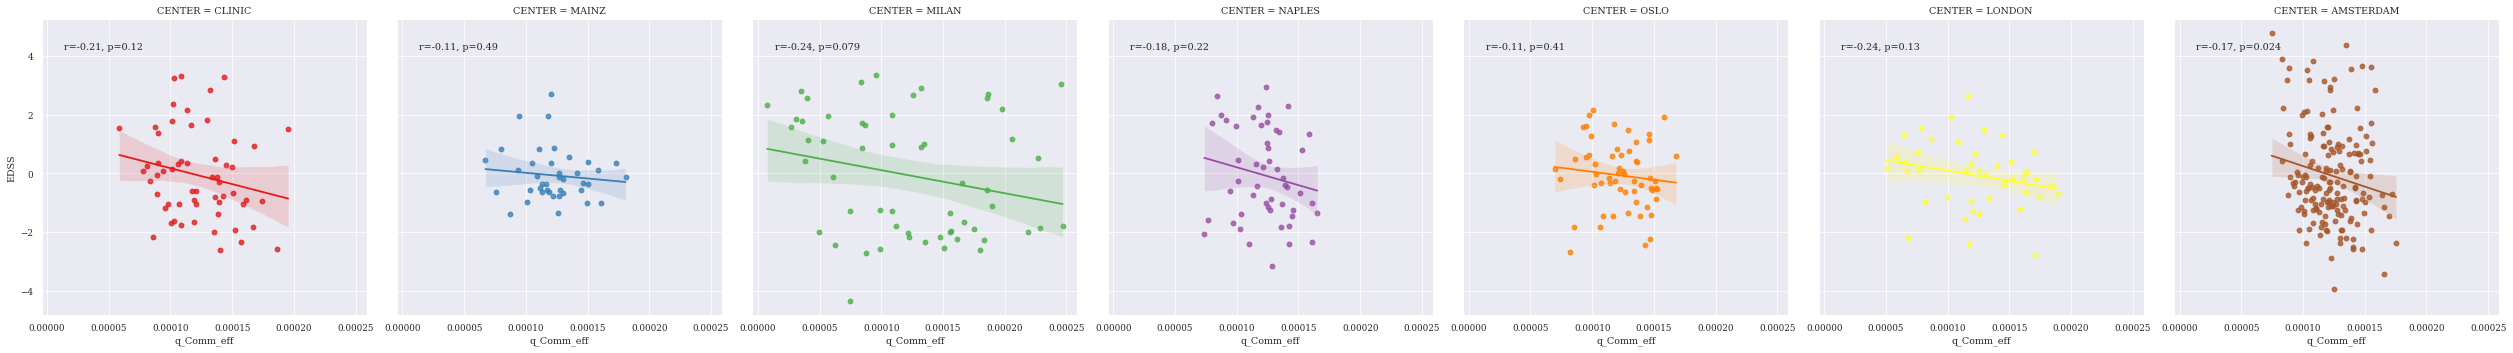

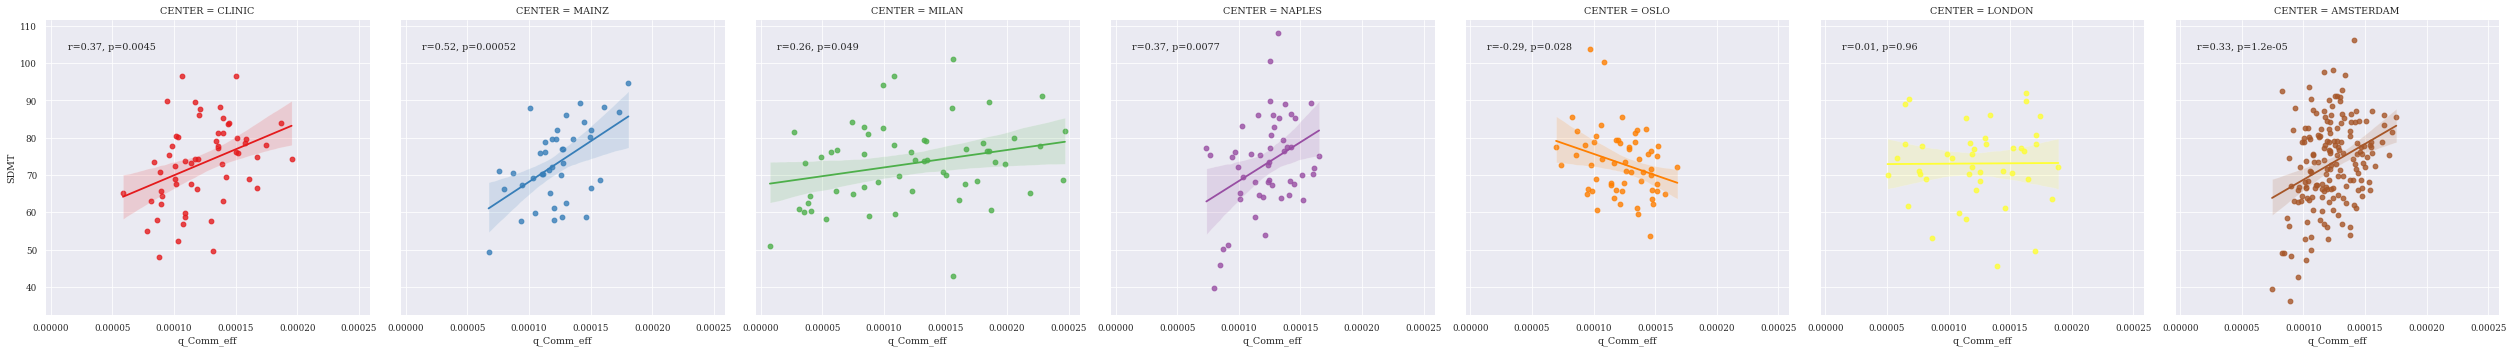

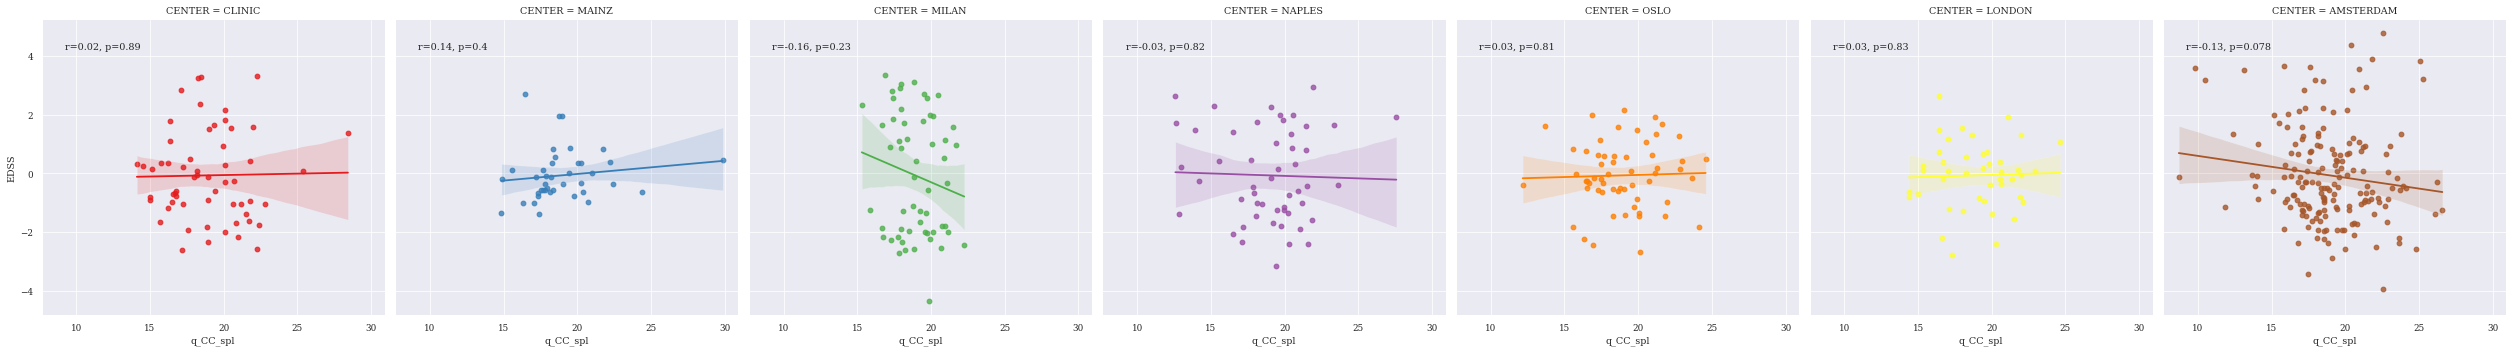

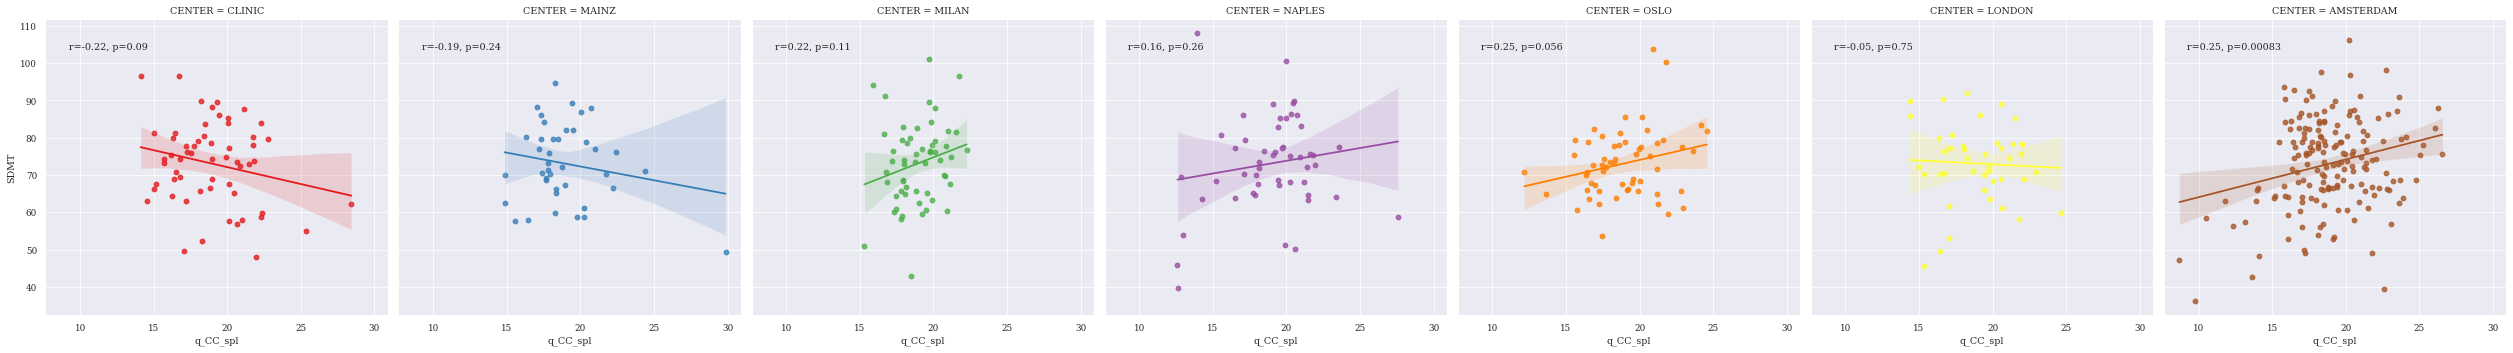

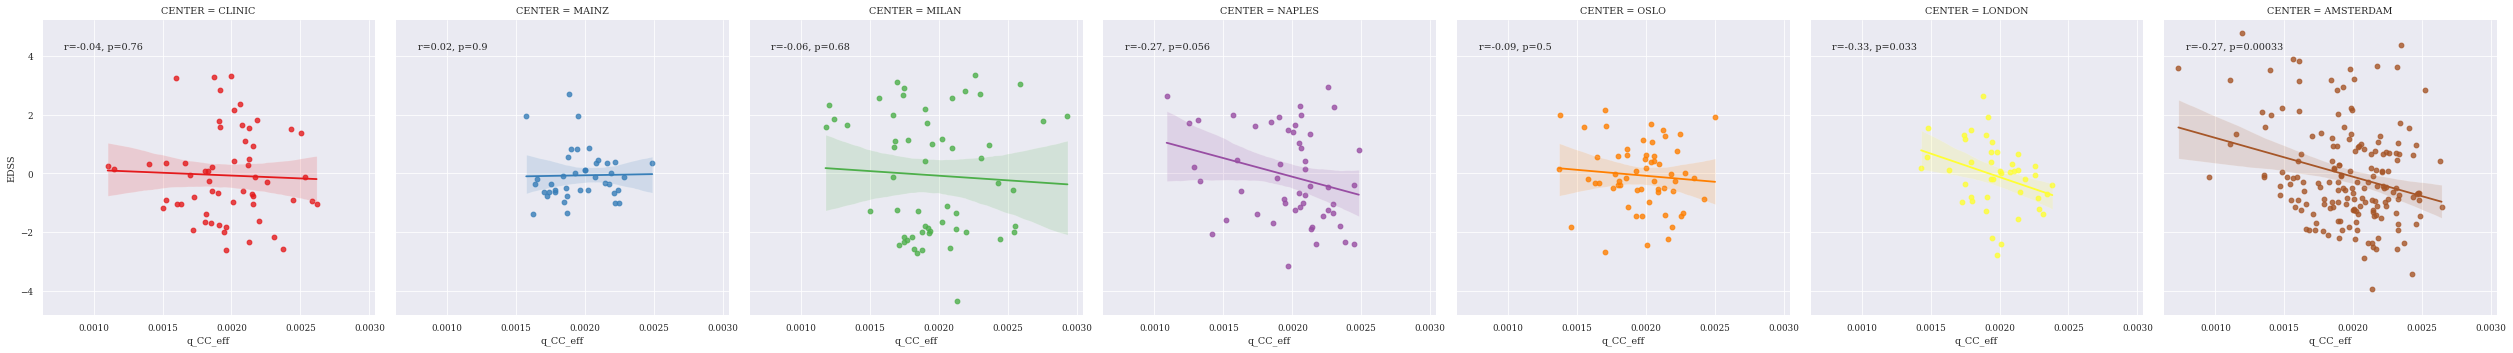

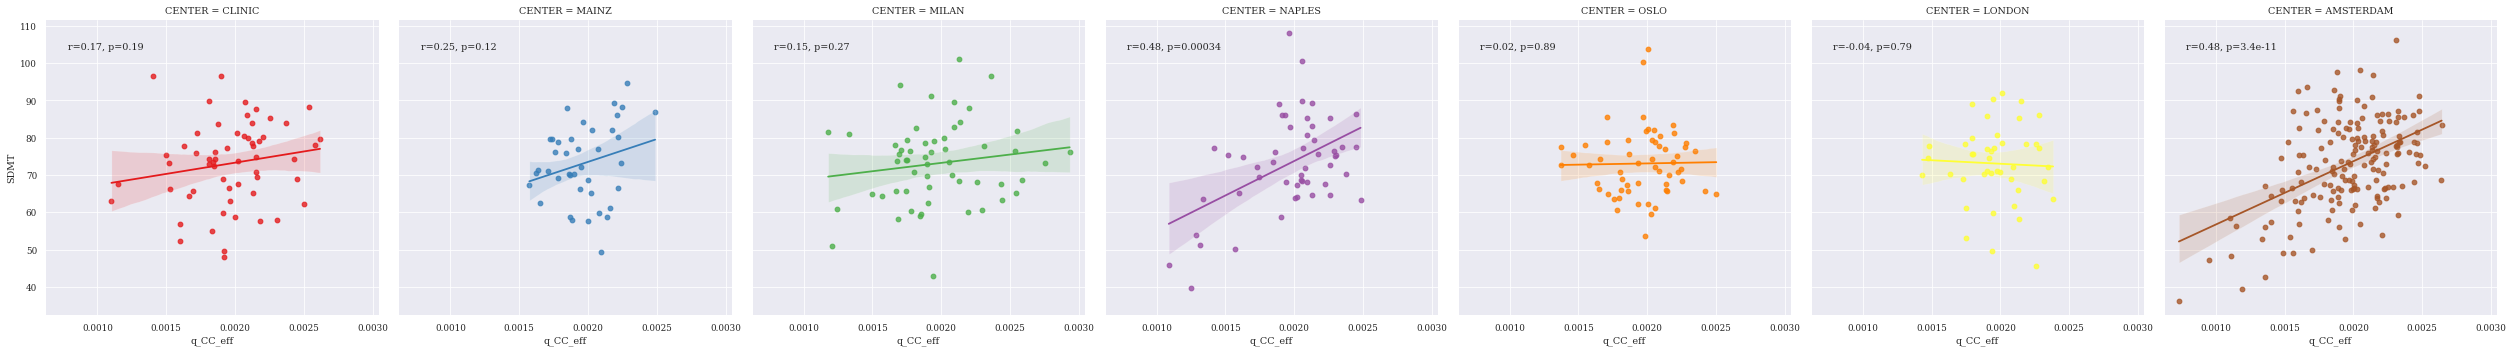

In [61]:
## Do it per center?
q_list = [x1, x2, x3, x4]
var_list = ["EDSS", "SDMT"]

for q in q_list:
    for var in var_list:
        g = sns.lmplot(data=df_merged_nona, x=f"{q}", y=f"{var}", col="CENTER", hue="CENTER")
        g.map_dataframe(annotate, f"{q}", f"{var}", multihue=False)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC vs. EDSS<3: t-test independent samples, P_val:8.661e-02 t=1.717e+00
EDSS<3 vs. EDSS>=3: t-test independent samples, P_val:2.328e-03 t=3.056e+00
SDMT>=40 vs. SDMT<40: t-test independent samples, P_val:4.285e-09 t=5.982e+00
HC vs. EDSS>=3: t-test independent samples, P_val:9.337e-07 t=4.953e+00
HC vs. SDMT>=40: t-test independent samples, P_val:2.493e-04 t=3.686e+00
HC vs. SDMT<40: t-test independent samples, P_val:2.015e-16 t=8.695e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC vs. EDSS<3: t-test independent samples, P_val:2.156e-01 t=1.240e+00
EDSS<3 vs. EDSS>=3: t-test independent samples, P_val:7.839e-03 t=2.667e+00
SDMT>=40 vs. SDMT<40: t-test independent samples,

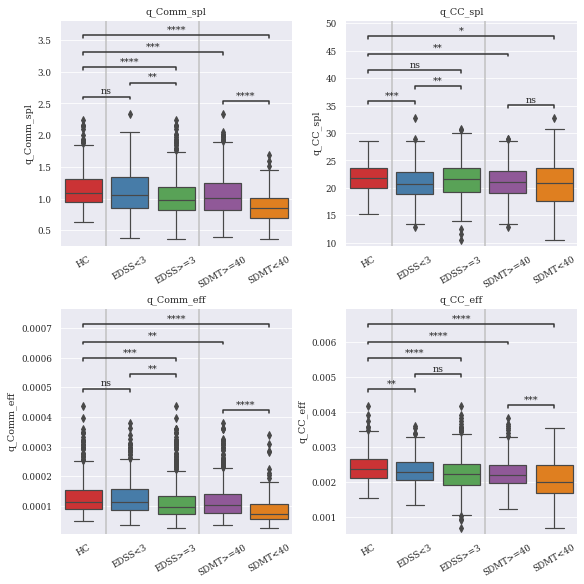

In [62]:
def create_dataframe_categories(df):
    """
    Create the dataframe with the new category and 
    return it
    """

    var_name = "groups"

    df_HC = df[df.GROUP == "HC"]
    df_HC[var_name] = "HC"

    df_lowEDSS = df[df.EDSS_group == "EDSS<3"]
    df_highEDSS = df[df.EDSS_group == "EDSS>=3"]

    df_lowEDSS[var_name] = "EDSS<3"
    df_highEDSS[var_name] = "EDSS>=3"

    # For the SDMT, remember not to include HC 
    df_lowSDMT = df[(df.SDMT_group == "SDMT<40") & (df.GROUP != "HC")]
    df_highSDMT = df[(df.SDMT_group == "SDMT>=40") & (df.GROUP != "HC")]

    df_lowSDMT[var_name] = "SDMT<40"
    df_highSDMT[var_name] = "SDMT>=40"

    # Concatenate all of the dfs
    df_out = pd.concat([df_HC, df_lowEDSS, df_highEDSS, df_lowSDMT, df_highSDMT])
    return df_out

df_merged = create_dataframe_categories(df_merged)

## Boxplot differences across groups
# paper
f, axes = plt.subplots(2, 2, figsize=(8,8), constrained_layout=True)

## left G, right cs
statest = "t-test_ind" # Mann-Whitney t-test_ind
axes = axes.T.ravel()
group_pairs = [("HC", "EDSS<3"), ("HC", "EDSS>=3"), ("HC", "SDMT<40"), ("HC", "SDMT>=40"), ("EDSS<3", "EDSS>=3"), ("SDMT<40", "SDMT>=40")]

# set vertical lines dividing categories
for ax in axes:
    ax.axvline(0.5, c="#C0C0C0", lw=1.5)
    ax.axvline(2.5, c="#C0C0C0", lw=1.5)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

# Average G
sns.boxplot(data=df_merged, x="groups", y=x1, order=map_hue_color["groups"], orient="v", ax=axes[0])
annotator = Annotator(axes[0], group_pairs, orient='v', data=df_merged, x="groups", y=x1, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[0].legend([],[], frameon=False)
axes[0].set_title(x1)
axes[0].set(xlabel=None)
axes[0].set_ylabel(x1)

# Individual G
sns.boxplot(data=df_merged, x="groups", y=x2, order=map_hue_color["groups"], orient="v", ax=axes[1])
annotator = Annotator(axes[1], group_pairs, orient='v', data=df_merged, x="groups", y=x2, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[1].legend([],[], frameon=False)
axes[1].set_title(x2)
axes[1].set(xlabel=None)
axes[1].set_ylabel(x2)

# Average osc G
sns.boxplot(data=df_merged, x="groups", y=x3, order=map_hue_color["groups"], orient="v", ax=axes[2])
annotator = Annotator(axes[2], group_pairs, orient='v', data=df_merged, x="groups", y=x3, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[2].legend([],[], frameon=False)
axes[2].set_title(x3)
axes[2].set(xlabel=None)
axes[2].set_ylabel(x3)

# Individual osc G
sns.boxplot(data=df_merged, x="groups", y=x4, order=map_hue_color["groups"], orient="v", ax=axes[3])
annotator = Annotator(axes[3], group_pairs, orient='v', data=df_merged, x="groups", y=x4, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[3].legend([],[], frameon=False)
axes[3].set_title(x4)
axes[3].set(xlabel=None)
axes[3].set_ylabel(x4)

#plt.tight_layout()

plt.savefig("/home/extop/GERARD/PAPERS/PAPER_COBRA/FIGURES/Boxplot_Quocients_EDSSSDMT_color.pdf", dpi=300)


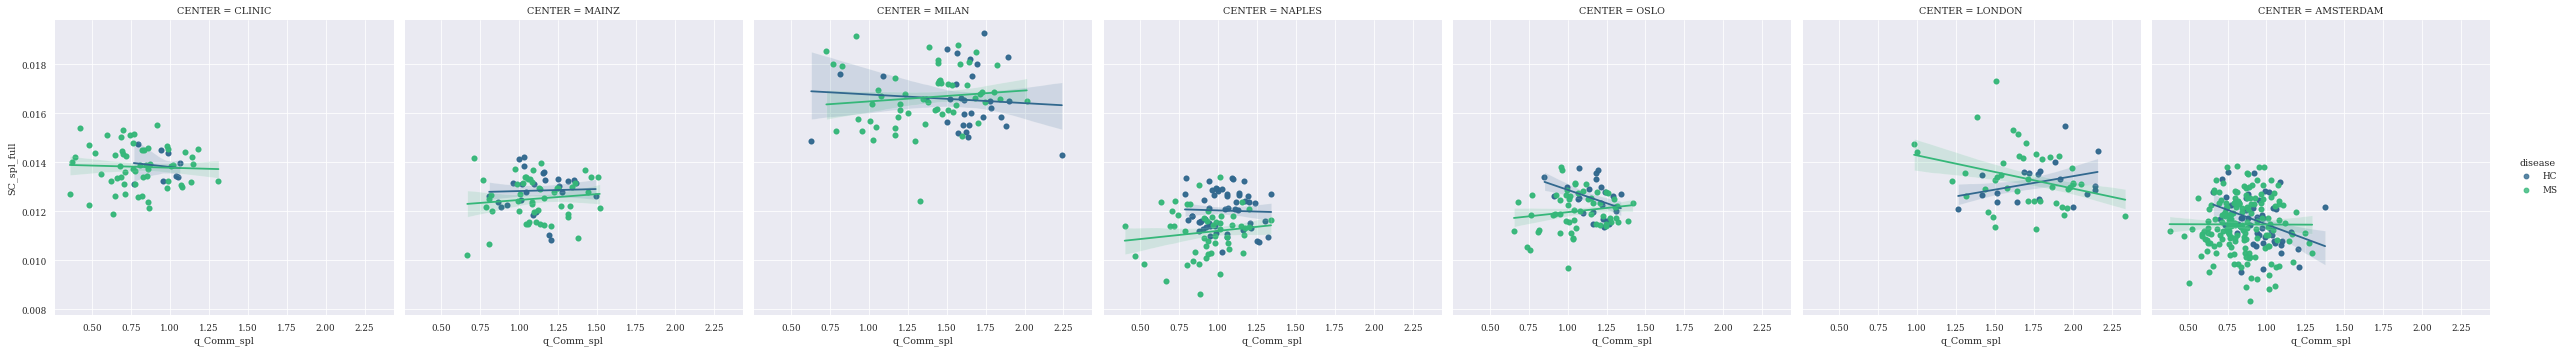

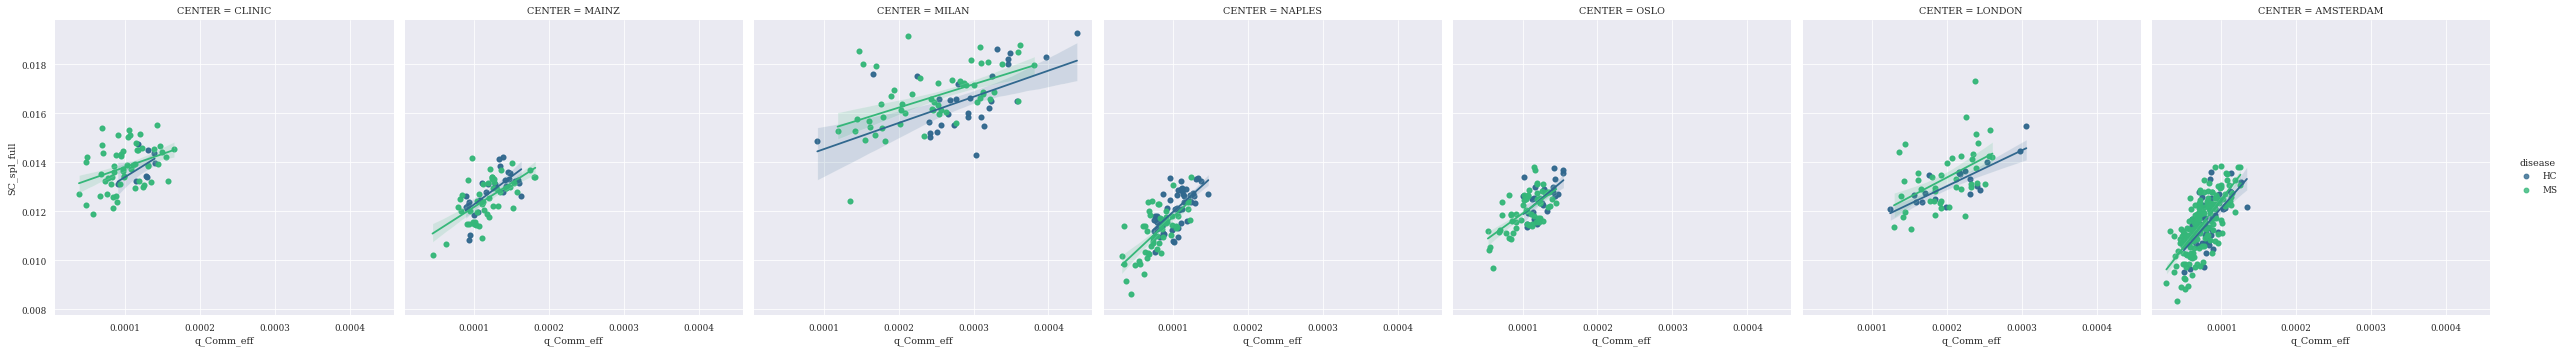

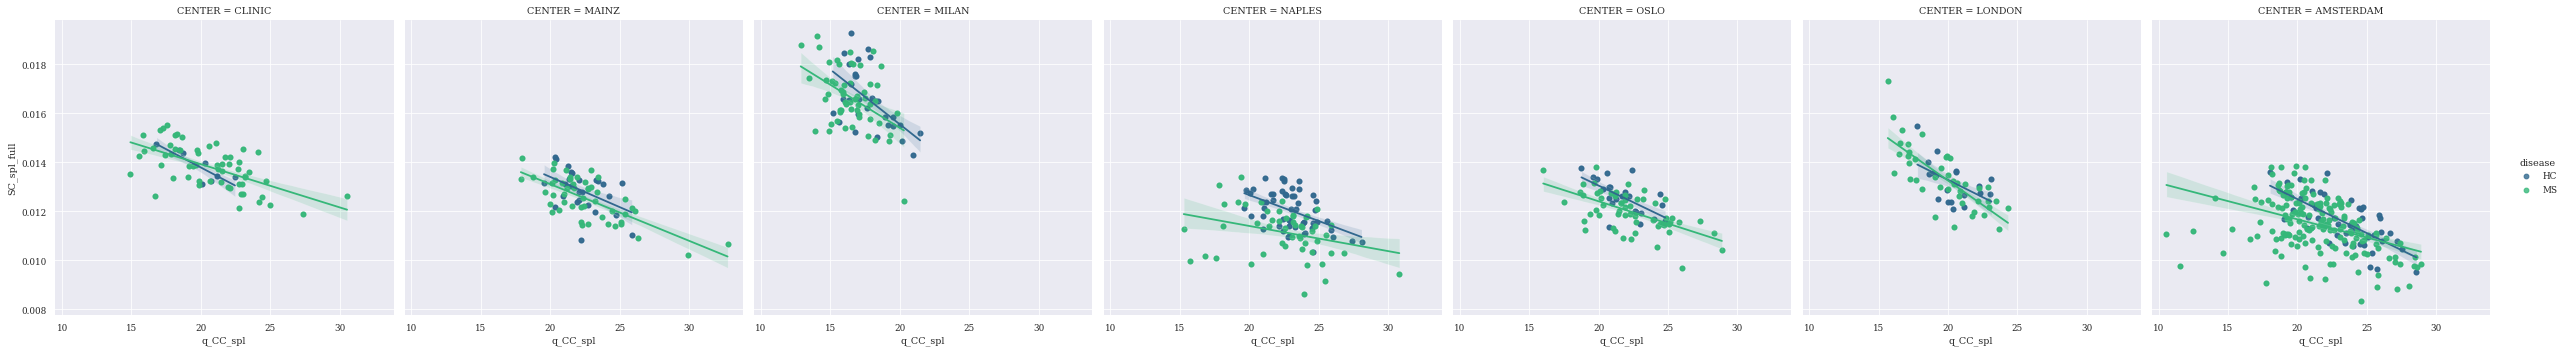

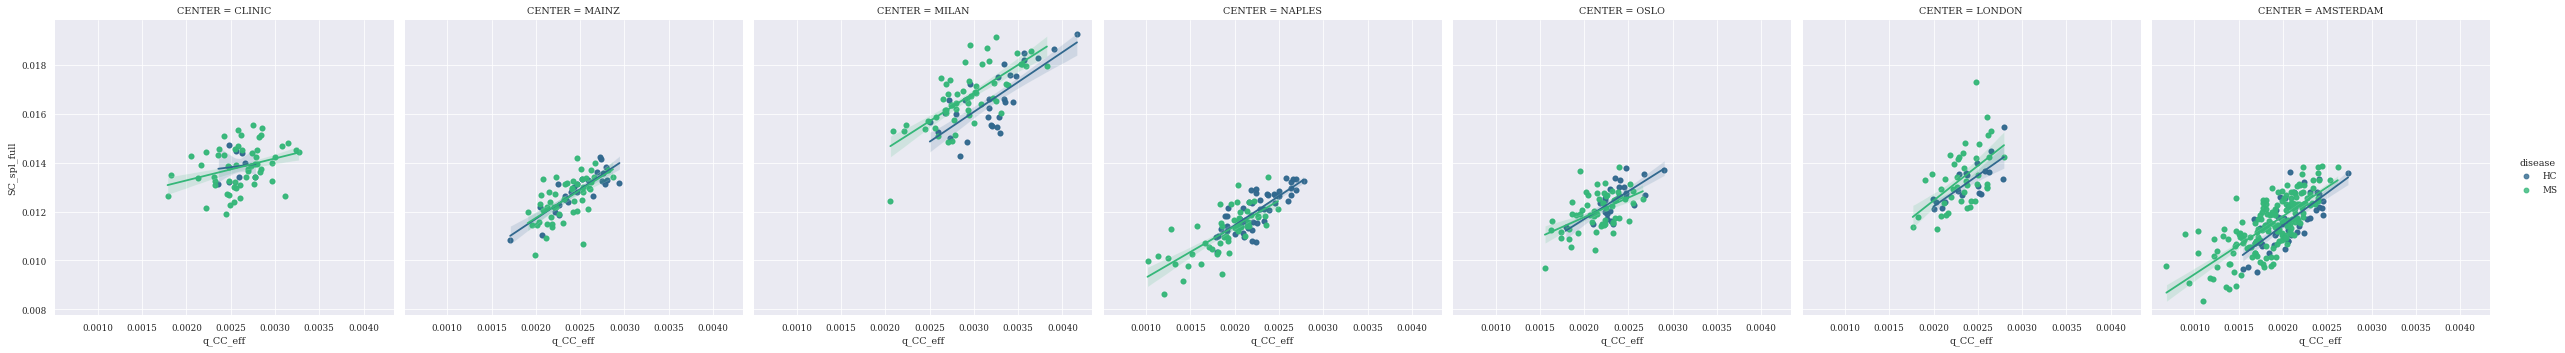

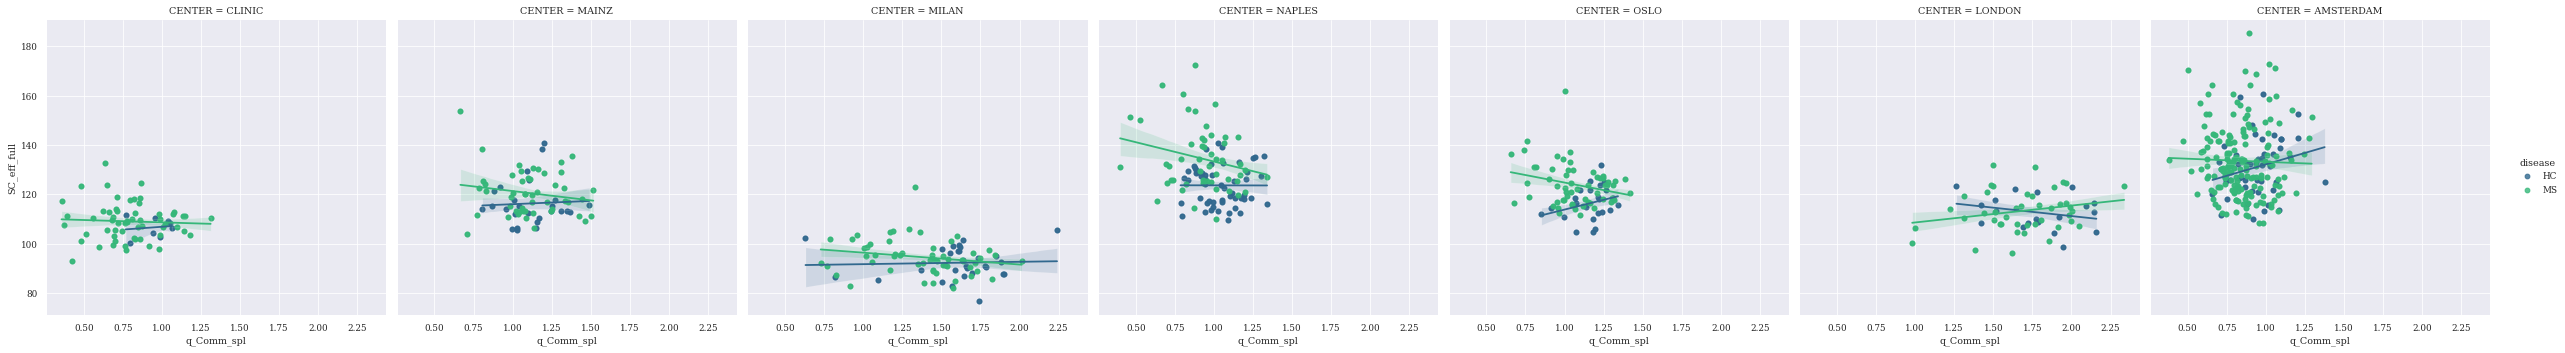

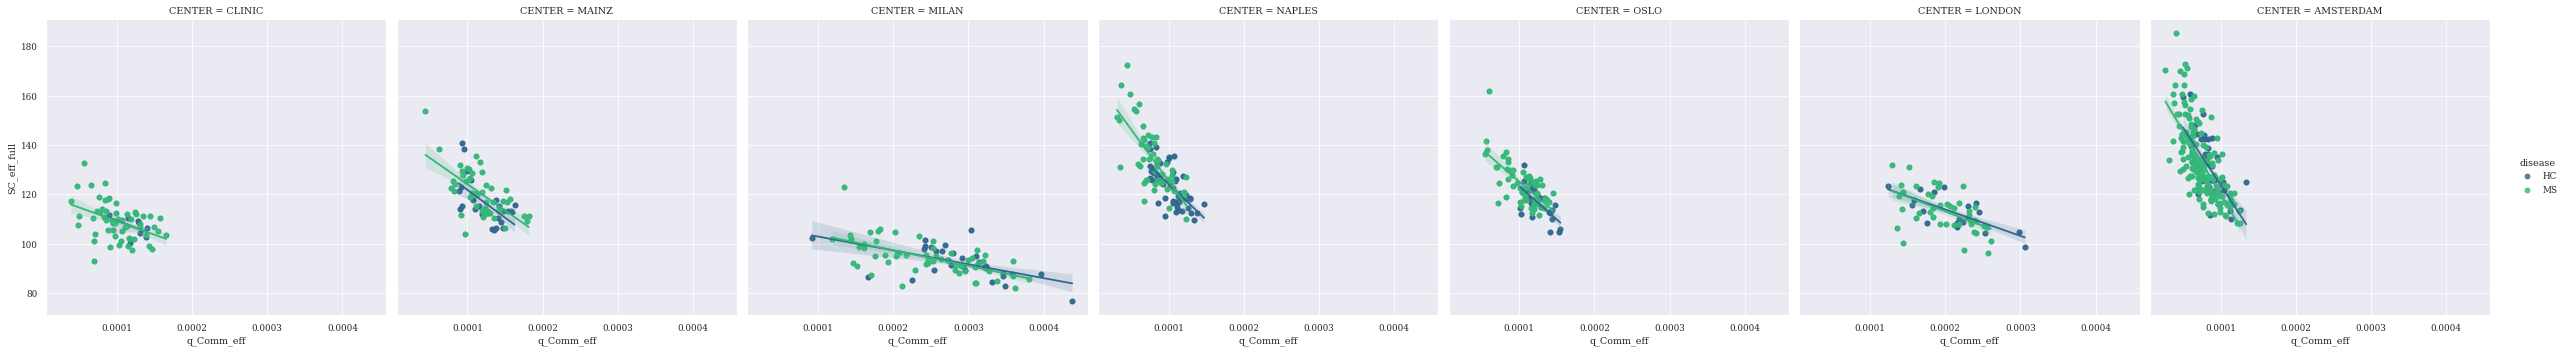

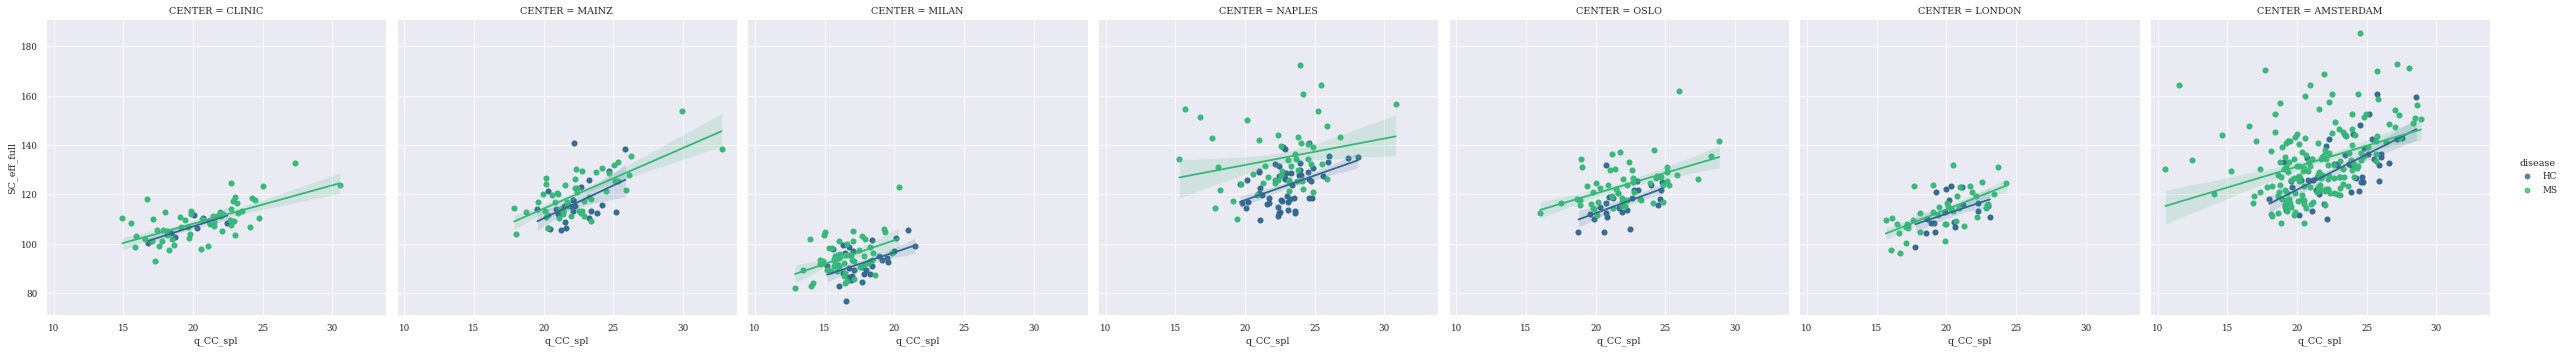

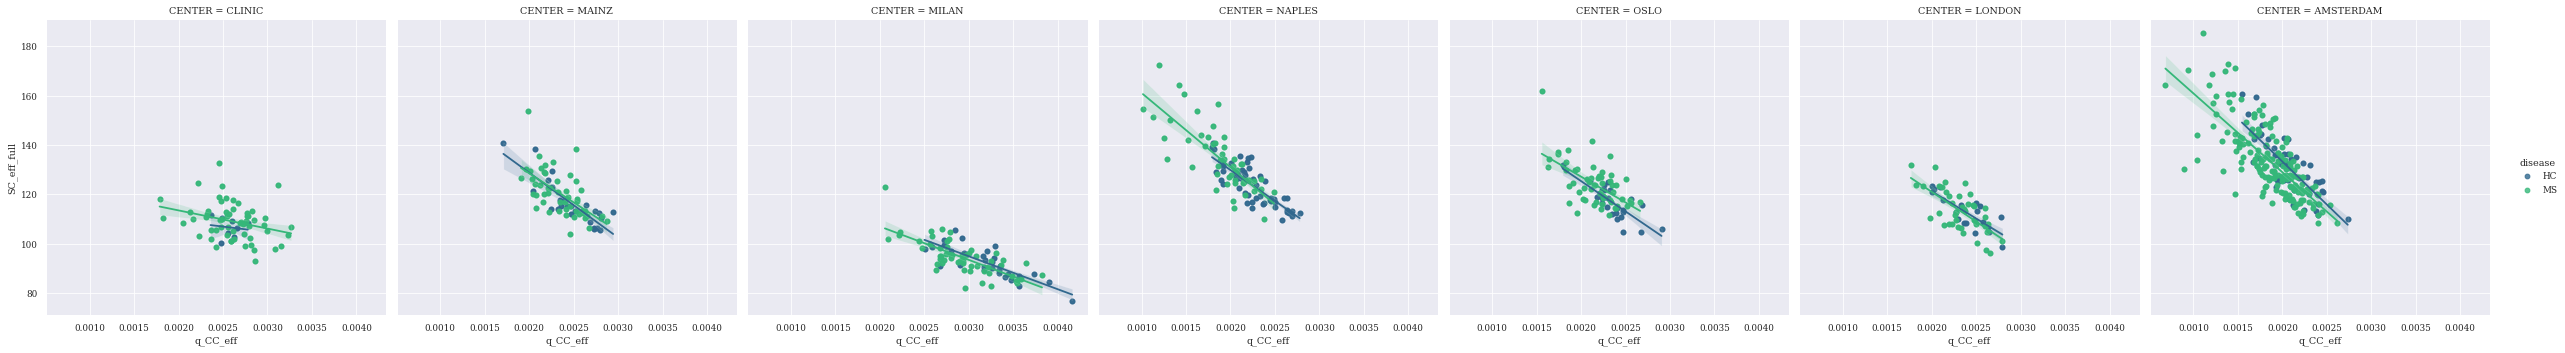

In [63]:
## Comparison with FC

# FC_values = ['FC_spl_full', 'FC_eff_full', 'FC_entropy_full', 'FC_integration_full', 'FC_Corr_total']
FC_values = ['CC_Sag_area', 'Full_CC', 'CC_ratio_area']
FC_values = ['SC_spl_full', 'SC_eff_full']

Q_list = [x1, x2, x3, x4]

for fc in FC_values:
    for qq in Q_list:
        df_plot = df_merged.dropna(subset=[fc, qq])
        g = sns.lmplot(data=df_merged, x=qq, y=fc, col="CENTER", hue='disease', fit_reg=True, scatter_kws={"alpha":0.8}, legend=True, legend_out=True, palette="viridis")
        # g.map_dataframe(annotate, fc, qq, multihue=False)

